In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
from Bio import SeqIO
from multiprocessing import Pool
from functools import partial

In [2]:
'''
Color encoding
'''
# SETTING
pixel_max = 254 #Customerization

# CHANNEL 0: BASE
base_color_stride = 70 #Customerization
offset_a_g = 40 #Customerization
offset_t_c = 30 #Customerization

# CHANNEL 1: BASE QUALITY
default_quality = 0
base_quality_cap = 40

# CHANNEL 2: MAPPING QUALITY
mapping_set_empty = 255 #Customerization
mapping_quality_cap = 60 #Customerization

# CHANNEL 3: ON POSITIVE STRAND
set_empty = 255 #Customerization
positive_strand = 70 #Customerization
negative_strand = 240 #Customerization

# CHANNEL 4: MATCH REFERENCE
pixel_max = 254 #Customerization
not_match_ref = pixel_max * 1 #Customerization
match_ref = pixel_max * 0.2 #Customerization
ref_not_provided = 255 #Customerization

# TO RGB
pixel_max_empty_def = 255

#############################################################################################
# CHANNEL 1: Base quality
    
def base_to_color_full_array_input(x):
    A = base_color_stride * 3 + offset_a_g
    T = base_color_stride * 2 + offset_t_c
    C = base_color_stride * 1 + offset_t_c
    G = base_color_stride * 0 + offset_a_g
    empty_to_fill = np.zeros(x.shape, dtype = np.int16)
    empty_to_fill[x == "A"] = A
    empty_to_fill[x == "T"] = T
    empty_to_fill[x == "C"] = C
    empty_to_fill[x == "G"] = G
    empty_to_fill[x == "a"] = A
    empty_to_fill[x == "t"] = T
    empty_to_fill[x == "c"] = C
    empty_to_fill[x == "g"] = G
    empty_to_fill[x == "N"] = 0
    empty_to_fill[x == "D"] = 0
    return empty_to_fill


# CHANNEL 1: Base quality
Quality_Score_Encoding = {"!":0,"\"":1,"#":2,"$":3,"%":4,"&":5,
                          "\'":6,"(":7,")":8,"*":9,"+":10,",":11,
                          "-":12,".":13,"/":14,"0":15,"1":16,"2":17,"3":18,
                         "4":19,"5":20,"6":21,"7":22,"8":23,"9":24,":":25,
                          ";":26,"<":27,"=":28,">":29,"?":30,"@":31,"A":32,
                         "B":33,"C":34,"D":35,"E":36,"F":37,"G":38,"H":39,"I":40}
def base_quality_mapping(x):
    if x in Quality_Score_Encoding.keys():
        quailty = Quality_Score_Encoding[x]
    else:
        quailty = default_quality

# CHANNEL 2: Mapping quality
def mapping_quality_fill(array, mapping_quality):
    
    to_fill = min(mapping_quality, mapping_quality_cap) / mapping_quality_cap * pixel_max
    mapping_quality_temp = np.full(array.shape, mapping_set_empty, dtype = np.int16)
    mapping_quality_temp[array != ""] = to_fill
    mapping_quality_temp[array == "N"] = mapping_set_empty
    mapping_quality_temp[array == "D"] = mapping_set_empty
    
    return mapping_quality_temp
    

# CHANNEL 3: On positive strand
def on_positive_strand_fill(array, positive_flag):
    
    on_positive_strand_temp = np.full(array.shape, set_empty, dtype = np.int16)
    to_fill = positive_strand

    binary_flag = np.binary_repr(positive_flag)
    if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
        to_fill = negative_strand
    
    on_positive_strand_temp[array != ""] = to_fill
    on_positive_strand_temp[array == "N"] = set_empty
    on_positive_strand_temp[array == "D"] = set_empty

    return on_positive_strand_temp


# CHANNEL 4: Match reference
def match_ref_fill(depth, window, array):
    
    empty = np.full((depth, window), ref_not_provided, dtype = np.int16)
    for i in np.arange(0, array.shape[1]):
        for j in np.arange(1, array.shape[0]):
            if array[j,i] == "":
                break
            elif array[j,i] == "N":
                if array[0,i] == "N":
                    break
                else:
                    empty[j,i] = not_match_ref
            elif array[j,i] == array[0,i]:
                empty[j,i] = match_ref
            else:
                empty[j,i] = ref_not_provided
    return empty


# COMBINE CHANNEL TO RGB
def channels_to_RGB(pixel_max_empty_def,
                    pre_image_base_color, 
                    pre_image_mapping_quality, 
                    pre_image_on_positive_strand, 
                    pre_image_match_ref, 
                    use_alpha = False):
    if use_alpha == True: 
        alpha = pre_image_match_ref / pixel_max_empty_def
        pre_image_base_color = np.multiply(pre_image_base_color, alpha)
        pre_image_mapping_quality = np.multiply(pre_image_mapping_quality, alpha)
        pre_image_on_positive_strand = np.multiply(pre_image_on_positive_strand, alpha)

    RGB = np.empty((pre_image_base_color.shape[0],pre_image_base_color.shape[1],pre_image_base_color.shape[2],3), dtype = np.int16)
    RGB[:,:,:,0] = pre_image_base_color
    RGB[:,:,:,1] = pre_image_mapping_quality
    RGB[:,:,:,2] = pre_image_on_positive_strand
    return RGB

In [3]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def make_list_of_searching_interval_of_scaffold(to_use_selected_scaffold_df):
    mask = np.zeros(scaffold_length, dtype = bool)
    searching_interval_selected = np.arange(1,(scaffold_length + 1))
    searching_locus_list = pd.Series([np.arange(a, b) for a, b in zip(to_use_selected_scaffold_df["expand start"], (to_use_selected_scaffold_df["expand end"] + 1))], to_use_selected_scaffold_df.index)
    for locus in searching_locus_list:
        mask[locus] = True
    searching_interval_unoverlapped = searching_interval_selected[mask]

    return consecutive(searching_interval_unoverlapped)

In [4]:
'''
Preprocessing
'''
def cigar_to_list(cigar): # NOT NEED TO USE THIS! THIS FUNCTION IS INCLUDED IN refine_read_by_cigar BELOW
    '''
    Deal with cigar 
    Split an unsplit cigar list to separated cigar array by number of each condition.
    
    2M3S1D2I to MMSSSDII
    
    Parameters
    ----------
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    cigar_list : 1D numpy array
        A array of cigar.
    '''
        
    separate = np.array([s.strip() for s in re.split(r"(\D+)", cigar)]) # Separate one element cigar list by cigar char 
    if separate[-1] == "": # Delete last empty element if it exists
        separate = separate[:-1]


    number = separate[::2].astype(int) # Extract number of each cigar
    cigar = separate[1::2] # Extract char of cigar

    # Cheack if number of elements in two list are same
    if len(number) != len(cigar): 
        print("elements are not the same")

    # If number of elements are same, make a array of cigar
    else:
        cigar_list = []
        for i in np.arange(0,len(number)):
            for j in np.arange(0,number[i]):
                cigar_list.append(cigar[i])
        cigar_list = np.array(cigar_list)
    
    return cigar_list

def refine_read_by_cigar(read, cigar): #PLEASE USE THIE TO MAKE REFINED READ FOR ALIGNMENT
    '''
    To refine reads by cigar list one by one.
    
    S : Directly delete it and move the behind forward
    I : Extract to make a list of inserted element with position and delete it, moving the behind forward
    D : Fill "D" in reads, move the behind backward
    N : Fill "N" in reads, move the behind backward
    M : Unchange
    
    Parameters
    ----------
    read : list
        One element unseperated read list.
    cigar : list
        One element unseperated cigar list.

    Returns
    -------
    refined_read : list
        unseparated list of refined-read
        
    refined_read_insert : 1D numpy array
        the inserted element
    
    refined_read_insert_index_at_ori_read : 1D numpy array
        the index of inserted element in the original read (from 0)
    
    refined_read_insert_index_at_refined_read : 1D numpy array
        the index of where to insert the inserted element on refined read (from 0)
    '''
    cigar_temp_list = cigar_to_list(cigar) # Read cigar and make cigar list by cigar_to_list function
    read_temp_list = np.array(list(read)) # Make list of read

    refined_read = [] # Make empty list for refined read
    ori_read_index = 0 # To keep the original read index for insertion point
    refined_read_index = 0 # To keep index of insertion point on refined read
    refined_read_insert = [] # Make empty list to keep the insertion
    refined_read_insert_index_at_ori_read = [] # FROM 0, make empty list to keep index of insertion on original read
    refined_read_insert_index_at_refined_read = [] #FROM 0, make empty list to keep index of insertion on refined read
    
    # From the first cigar, fill the refined read one by one with original read dependent on the cigar
    ## If cigar(+), ori-read(-):
        ## "D", only refined-index move forward
        ## "N", only refined-index move forward
    ## If cigar(+), ori-read(+): 
        ## "I", only ori-index move forward, but save the information of insertion
        ## "S", only ori-index move forward
        ## "M", two of the index move forward
    for index, cigar in enumerate(cigar_temp_list): 
        if cigar == "S": #Directly ignore it and move the behind forward
            ori_read_index += 1 # Move forward on original index
            continue
        
        if cigar == "H": #Directly ignore it and move the behind forward
            continue
            
        if cigar == "I": #Extract to make a list of inserted element with position and ignore it, moving the behind forward
            refined_read_insert.append(read_temp_list[ori_read_index]) # Save the base
            refined_read_insert_index_at_ori_read.append(ori_read_index) # Save where it is on original read 
            refined_read_insert_index_at_refined_read.append(refined_read_index) # Save where it will be on refined read
            ori_read_index += 1 # Move forward on original index
            continue
            
        if cigar == "D": # Fill "D" in refined read
            refined_read.append("D") # Fill "D"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "N": # Fill "N" in refined read
            refined_read.append("N") # Fill "N"
            refined_read_index += 1 # Move forward on refined_read_index
            continue
            
        if cigar == "M": # Fill the base in refined read
            refined_read.append(read_temp_list[ori_read_index]) # Fill the base
            ori_read_index += 1 # Move forward on original read index
            refined_read_index += 1 # Move forward on refined read index
            continue
            
        else:
            print(cigar,"is not defined at",index) # If there is any exception, print it
            
    refined_read = "".join(refined_read) # Combine list of the base pair 
    refined_read_insert = np.array(refined_read_insert)
    refined_read_insert_index_at_ori_read = np.array(refined_read_insert_index_at_ori_read)
    refined_read_insert_index_at_refined_read = np.array(refined_read_insert_index_at_refined_read)
    return refined_read, refined_read_insert, refined_read_insert_index_at_ori_read, refined_read_insert_index_at_refined_read


def find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df):
    '''
    To find if there is any insertion in the window of one locus, 
    and make dataframes of insertion forward and backward respectively
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    skip range : int
        The range skipped.
    window : int
        The window of one locus.
    read_selected_matrix : numpy array
        2D array that includes the information of reads covering one locus
    to_use_selected_scaffold_df : pandas.DataFrame
        

    Returns
    -------
    forward_df : pandas.DataFrame
        a dataframe saving the information of forward insertion : read, index, base, read order
        
    backward_df : pandas.DataFrame
        a dataframe saving the information of backward insertion : read, index, base, read order
    '''
    forward_i_read = []
    forward_i_index = []
    forward_i_base = []
    forward_i_read_order = [] # FRPM 0 

    backward_i_read = []
    backward_i_index = []
    backward_i_base = []
    backward_i_read_order = [] # FROM 0
    
    # For every read that covers one locus
    for read_order, reads in enumerate(read_selected_matrix[(index - skip_range)]): 
        
        if np.isnan(reads): # Until no read, stop the iteration
            break

        refined_read_i_index = index - to_use_selected_scaffold_df["start"][reads] # To find the index of the locus on one read
        start_insertion_index = refined_read_i_index - ((window - 1) / 2) # To find the start point of one read that would be inside the window
        end_insertion_index = refined_read_i_index + ((window - 1) / 2) - 1 # To find the end point of one read that would be inside the window
        
        # Check every insertion index of one read
        for insertion_index in to_use_selected_scaffold_df["ori insertion index"][reads]:
            if refined_read_i_index <= insertion_index <= end_insertion_index: # If it is after the middle locus but before the end point
                forward_i_read.append(reads) # Add the reads
                forward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                forward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                forward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  

            elif start_insertion_index <= insertion_index <= (refined_read_i_index - 1): # If it is before the middle locus but after the end point
                backward_i_read.append(reads) # Add the reads
                backward_i_index.append(to_use_selected_scaffold_df["start"][reads] + insertion_index) # Where to insert on original index of scaffold
                backward_i_base.append(to_use_selected_scaffold_df["read"][reads][insertion_index]) # Add the base
                backward_i_read_order.append(read_order) # Add the read order which means the depth if plus 1 cause the first is ref  
                
    forward_df = pd.DataFrame({"read": forward_i_read, "index": forward_i_index, "base":forward_i_base, "read order":forward_i_read_order}) # Make the dataframe
    backward_df = pd.DataFrame({"read": backward_i_read, "index": backward_i_index, "base":backward_i_base, "read order":backward_i_read_order}) # Make the dataframe
    
    return forward_df, backward_df


def insertion_fill_in(index, depth, window, pre_image_char_part, forward_df, backward_df):
    '''
    If there is any insertion in the window of one locus,
    insert it and move the other bases forward and backward 
    than delete the exceed
    
    Parameters
    ----------
    index : int
        The locus of scaffold.
    depth : int
        The depth.
    window : int
        The window of one locus.
    pre_image_char_part : 2D numpy array
        The 2D array of one locus: pre_image_char_part = pre_image_char[(index - skip_range),:,:]
    forward_df : pandas.DataFrame
        The forward dataframe generated by find_insertion_forbackward function
    backward_df : pandas.DataFrame
        The backward dataframe generated by find_insertion_forbackward function

    Returns
    -------
    pre_image_char_part_output : 2D numpy array
        a new 2D array of one locus to replace the original one
    '''
    # To sort the forward dataframe, ascending order(1->2->3...)
    forward_df = forward_df.sort_values(by = "index", ascending = True)
    
    # To extract read order, index, base from forward dataframe
    for for_read_order, for_index, for_base in zip(forward_df["read order"], forward_df["index"], forward_df["base"]):
        insertion_location = int(for_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[for_read_order + 1] = for_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it
    
    # To sort the backward dataframe, descending order(3->2->1...)
    backward_df = backward_df.sort_values(by = "index", ascending = False)
    
    # To count how many insertion backward for final cutting of the matrix
    cut_length = len(backward_df)
    
    # To extract read order, index, base from backward dataframe
    for back_read_order, back_index, back_base in zip(backward_df["read order"], backward_df["index"], backward_df["base"]):
        insertion_location = int(back_index - index + ((window - 1) / 2)) # To find the insertion location in the window
        insertion_array = np.chararray(depth, unicode = True) # Make a empty array to insert
        insertion_array[back_read_order + 1] = back_base # Add the insertion base to the empty array
        pre_image_char_part = np.insert(pre_image_char_part, insertion_location, insertion_array, 1) # Insert it

    # Cut the required part: if 2 backward insertion and 3 forward insertion with window, extract 2 : 2+window-1    
    pre_image_char_part_output = pre_image_char_part[:,(cut_length):(cut_length + window)]
    
    return pre_image_char_part_output

In [5]:
'''
Read fasta file
'''
def read_fasta(fasta):
    fasta_sequences = SeqIO.parse(open(fasta),"fasta")
    fasta_name = []
    fasta_sequence = []
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        fasta_name.append(name)
        fasta_sequence.append(sequence)
    fasta_dict = {"scaffold":fasta_name,"sequence":fasta_sequence}
    fasta_df = pd.DataFrame(fasta_dict)
    fasta_df["len"] = fasta_df["sequence"].str.len()
    return fasta_df

In [6]:
'''
Read sam file
'''
def read_sam(samfile):
    # Read sam file
    sam=[]
    with open(samfile, "r") as f:
        for line in f.readlines():
            sam.append(line.split("\t"))
    sam = np.array(sam)
    return sam

In [7]:
'''
Scaffold fliter
'''
def scaffold_min_and_max(fasta_df, minimum, maximum):
    mask_min = (fasta_df["len"] >= minimum)
    mask_max = (fasta_df["len"] <= maximum)
    fasta_df_fliter = fasta_df[(mask_min & mask_max)]
    return fasta_df_fliter

In [8]:
'''
For each scaffold, find coveraging read in the sam
'''
def find_read_based_on_scaffold(scaffold_name, sam):
    # Find index of selected scaffold in bam
    scaffold_in_sam = list([i for i,item in enumerate(sam) if scaffold_name in item])

    # Make a DataFrame for selected scaffold information

    selected_scaffold_df = [sam[i] for i in scaffold_in_sam]
    selected_scaffold_df = pd.DataFrame(selected_scaffold_df)
    return selected_scaffold_df

In [9]:
'''
Select useful information in dafaframe of selected scaffold
'''
def make_read_scaffold_df(selected_scaffold_df, expand = 0):
    scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    
    pd.options.mode.chained_assignment = None
    to_use_selected_scaffold_df_pre = selected_scaffold_df[[1,2,3,4,5,9]]
    to_use_selected_scaffold_df = to_use_selected_scaffold_df_pre[to_use_selected_scaffold_df_pre[9] != "*"]
    to_use_selected_scaffold_df.columns = ["flag","scaffold","start","mapping quality","cigar","read"]
    to_use_selected_scaffold_df["read length"] = to_use_selected_scaffold_df["read"].str.len()
    to_use_selected_scaffold_df["start"] = to_use_selected_scaffold_df["start"].astype('int64')
    to_use_selected_scaffold_df["mapping quality"] = to_use_selected_scaffold_df["mapping quality"].astype('int64')
    to_use_selected_scaffold_df["flag"] = to_use_selected_scaffold_df["flag"].astype('int64')
    to_use_selected_scaffold_df["end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["read length"] - 1)
    to_use_selected_scaffold_df["refined_by_cigar"] = to_use_selected_scaffold_df.apply(lambda x: refine_read_by_cigar(x["read"], x["cigar"]), axis=1)
    to_use_selected_scaffold_df[["refined read", 
                                 "insertion",
                                 "ori insertion index",
                                 "re insertion index"]] = pd.DataFrame(to_use_selected_scaffold_df["refined_by_cigar"].tolist(), index=to_use_selected_scaffold_df.index)
    to_use_selected_scaffold_df.drop(columns=["refined_by_cigar"],inplace=True)
    to_use_selected_scaffold_df["refined read length"] = to_use_selected_scaffold_df["refined read"].str.len()
    to_use_selected_scaffold_df["refined end"] = (to_use_selected_scaffold_df["start"] + to_use_selected_scaffold_df["refined read length"] - 1)
    to_use_selected_scaffold_df["expand start"] = (to_use_selected_scaffold_df["start"] - expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand start"] < 1, "expand start"] = 1
    to_use_selected_scaffold_df["expand end"] = (to_use_selected_scaffold_df["refined end"] + expand)
    to_use_selected_scaffold_df.loc[to_use_selected_scaffold_df["expand end"] > scaffold_length, "expand end"] = scaffold_length
    
    return to_use_selected_scaffold_df

In [ ]:
'''
Make a matrix of reads which meet the criteria of each locus
'''
def make_read_selected_matrix_find_reads(index, ONLY_FILL_THE_LONGEST = True):
    mask1 = to_use_selected_scaffold_df["start"] <= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    mask2 = to_use_selected_scaffold_df["refined end"] >= index + ALL_TOUCH_INCLUDED * ((window + 1) / 2)
    read_selected_array = np.empty(depth)
    read_selected_array[:] = np.nan
    if ONLY_FILL_THE_LONGEST == True:
        if len(to_use_selected_scaffold_df[(mask1 & mask2)]["read length"]) != 0:
            read_selected_array[0:1] = to_use_selected_scaffold_df[(mask1 & mask2)]["read length"].idxmax()
        
    else:
        length = len(to_use_selected_scaffold_df[(mask1 & mask2)].index)
        read_selected_array[0:length] = to_use_selected_scaffold_df[(mask1 & mask2)].index
    
    return read_selected_array

def make_read_selected_matrix(scaffold_name, searching_interval, to_use_selected_scaffold_df, window, skip_range, depth, core = 20):
    
    # Interval for searching
    searching_interval_length = len(searching_interval)

    # Search every base that are in this interval
    # And select feasible reads for each base on locus of genome
    if __name__ == "__main__" :  
        
        pool = Pool(core) # Pool() 
        read_selected_matrix = pool.map(make_read_selected_matrix_find_reads, searching_interval) 
        pool.close()  
        pool.join()   
    
    read_selected_matrix = np.array(read_selected_matrix)
        
    return read_selected_matrix

In [11]:
'''
Make a 4 dimension matrix of pre-image base 
'''
def image_pileup_Parallelism(to_use_selected_scaffold_df, read_selected_matrix, index, INSERTION = False, REVERSE_FOR_NEG = True):
    # To search the base based on index
    # From index=0~the last one, means from the first one to the last
    pre_pre_image_char_matrix = np.chararray((depth, window), unicode = True)
    # FIRST!!! FILL ref at depth=0
    # From start point "0" to end point "window - 1" 
    middle = ((window - 1) / 2) # Index not order
    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]

    # at "0" fill: (index - middle)
    # at "coverage interval - 1" fill: (index + middle) 
    # This is index of what to fill
    fasta_fill_index_start = (index - middle) # Order not index
    fasta_fill_index_end = (index + middle) # Order not index

    # Set all the element to "N" first
    pre_pre_image_char_matrix[0, :] = "N"
    base_fill_index_start = 0
    base_fill_index_end = window
    if fasta_fill_index_start < 1:
        base_fill_index_start = int(np.abs(fasta_fill_index_start - 1))
        fasta_fill_index_start = 1

    elif fasta_fill_index_end > scaffold_max_length:
        base_fill_index_end = int((scaffold_max_length - fasta_fill_index_end))
        fasta_fill_index_end = scaffold_max_length
    
    pre_pre_image_char_matrix[0, base_fill_index_start:base_fill_index_end] = np.array(list(fasta_df[fasta_df["scaffold"]==scaffold_name]["sequence"].values[0][int(fasta_fill_index_start - 1):int(fasta_fill_index_end)]))   
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break

        else:
            read_start = to_use_selected_scaffold_df["start"][reads] # To find the start point of the read
            read_end = to_use_selected_scaffold_df["refined end"][reads] # To find the end point of the read

            pre_pre_image_char_matrix[(i+1), :] = "N"
            image_read_fill_start = 0
            image_read_fill_end = int(window)
            read_fill_start = int(fasta_fill_index_start - read_start)
            read_fill_end = int(fasta_fill_index_end - read_start) + 1

            if read_start > fasta_fill_index_start:
                image_read_fill_start = int(read_start - fasta_fill_index_start)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][:read_fill_end]))

            elif read_end < fasta_fill_index_end:
                image_read_fill_end = int(read_end - fasta_fill_index_end)
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:]))

            else:    
                pre_pre_image_char_matrix[(i+1), image_read_fill_start:image_read_fill_end] = np.array(list(to_use_selected_scaffold_df["refined read"][reads][read_fill_start:read_fill_end]))
    
    ##################### DEAL WITH N #######################################\
    for i in np.arange(0, pre_pre_image_char_matrix.shape[1]): # For all the element in the window
        if pre_pre_image_char_matrix[0, i] == "N": # Check the top element is "N" or not
            A = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "A") # Count "A" 
            T = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "T") # Count "T"
            C = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "C") # Count "C"
            G = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "G") # Count "G"
            N = np.count_nonzero(pre_pre_image_char_matrix[:, i] == "N") # Count "N"

            base_count_list = np.array([A, T, C, G, N]) # Make a list of base
            base_unique_list = np.array(["A", "T", "C", "G", "N"]) # Make a list of index of the base
            base_count_list_sort = np.sort(base_count_list) # Sort the list of base
            if base_count_list_sort[-1] != base_count_list_sort[-2]: # To check if there any duplicated most frequent elements
                pre_pre_image_char_matrix[0, i] == base_unique_list[base_count_list.argmax()] # If no, fill the most frequent one
    
    ####################################### INSERTION #######################################
    if INSERTION == True:
        forward_df, backward_df = find_insertion_forbackward(index, skip_range, window, read_selected_matrix, to_use_selected_scaffold_df)
        if (len(forward_df) != 0) or  (len(backward_df) != 0): # If there is any insertion, use pre_image_char function
            pre_pre_image_char_matrix = insertion_fill_in(index, depth, window, pre_pre_image_char_matrix, forward_df, backward_df)
            
    ####################################### REVERSE STRAND IF ON NEGATIVE STRAND #######################################
    if REVERSE_FOR_NEG == True:
        if pre_pre_image_char_matrix.shape[0] == 2:
            reads = read_selected_matrix[(index - skip_range)][0]
            if not np.isnan(reads):
                positive_flag = to_use_selected_scaffold_df["flag"][reads]
                binary_flag = np.binary_repr(positive_flag)
                if (len(binary_flag) >= 5) and (list(binary_flag)[-5] == "1"):
                    pre_pre_image_char_matrix = np.flip(pre_pre_image_char_matrix, axis = 1)
                    reverse_temp = pre_pre_image_char_matrix
                    reverse_temp[pre_pre_image_char_matrix == "A"] = "T"
                    reverse_temp[pre_pre_image_char_matrix == "T"] = "A"
                    reverse_temp[pre_pre_image_char_matrix == "C"] = "G"
                    reverse_temp[pre_pre_image_char_matrix == "G"] = "C"
                    pre_pre_image_char_matrix = reverse_temp
        else:
            print("REVERSE_FOR_NEG is only for depth=2")
    
    ####################################### COLOR
    pre_image_base_color = base_to_color_full_array_input(pre_pre_image_char_matrix) 
    
    ####################################### MAPPING QUALITY
    pre_image_mapping_quality_temp = np.full(pre_pre_image_char_matrix.shape, mapping_set_empty)
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break
        else:
            mapping_quality = to_use_selected_scaffold_df["mapping quality"][reads]
            pre_image_mapping_quality_temp[(i + 1), :] = mapping_quality_fill(pre_pre_image_char_matrix[(i+1), :], mapping_quality)
    ####################################### ON POSITIVE STRAND
    on_positive_strand_temp = np.full(pre_pre_image_char_matrix.shape, on_positive_strand_not_provide)
    
    for i, reads in enumerate(read_selected_matrix[(index - skip_range)]):
        # If there is no read or until the end of the coverage, jump to the next locus
        if np.isnan(reads):
            break
        else:
            positive_flag = to_use_selected_scaffold_df["flag"][reads]
            on_positive_strand_temp[(i + 1), :] = on_positive_strand_fill(pre_pre_image_char_matrix[(i+1), :], positive_flag)
    ####################################### MATCH REF
    pre_image_match_ref_temp = match_ref_fill(depth, window, pre_pre_image_char_matrix)
    
    return pre_image_base_color, pre_image_mapping_quality_temp, on_positive_strand_temp, pre_image_match_ref_temp


def image_pileup(scaffold_name, 
                 fasta_df, 
                 read_selected_matrix, 
                 to_use_selected_scaffold_df, 
                 window, 
                 depth, 
                 searching_interval, 
                 pixel_max, 
                 bias_of_read, 
                 mapping_quality_not_provide, 
                 on_positive_strand_not_provide, 
                 not_match_ref, core = 20):
    
    # 3 dimention maxtrix initialization: base(char), base color(int), base quality(char), on postive strand(int)
    ## x: searching_interval 
    ## y: depth
    ## z: coverage read interval
    ####coverage_interval = (length_of_read * 2 -1 + bias_of_read) 
    window = 149
    searching_interval_length = len(searching_interval)

    scaffold_max_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    middle = ((window - 1) / 2) # Index not order
    
    # FIRST!!! FILL REF
    # SECOND!!! FILL read at depth=1~
    if __name__ == "__main__" :  
        pre_image_base_color = []
        pre_image_mapping_quality = []
        pre_image_on_positive_strand = []
        pre_image_match_ref = []
        
        
        
        pool = Pool(core) # Pool() 
        func = partial(image_pileup_Parallelism, to_use_selected_scaffold_df, read_selected_matrix)
        for pre_image_base_color_locus, pre_image_mapping_quality_locus, pre_image_on_positive_strand_locus,pre_image_match_ref_locus in pool.map(func, searching_interval, chunksize=500):
            pre_image_base_color.append(pre_image_base_color_locus)
            pre_image_mapping_quality.append(pre_image_mapping_quality_locus)
            pre_image_on_positive_strand.append(pre_image_on_positive_strand_locus)
            pre_image_match_ref.append(pre_image_match_ref_locus)
            
        pool.close()  
        pool.join()  
        
    #pre_image_char = np.array(pre_image_char)
    pre_image_base_color = np.array(pre_image_base_color)
    pre_image_mapping_quality = np.array(pre_image_mapping_quality)
    pre_image_on_positive_strand = np.array(pre_image_on_positive_strand)
    pre_image_match_ref = np.array(pre_image_match_ref)
    
 
    return pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref

In [12]:
'''
Visualization of one locus
'''
def visualization_locus(locus, RGB):
    final_plot = RGB
    final_index = locus
    print(final_index)

    plt.figure(figsize=(30,5))
    plt.subplot(4,1,1)
    plt.imshow(final_plot[final_index,:,:,:])
    plt.title("Locus = %s" %locus)
    plt.ylabel("RGB")
    plt.show()

    plt.figure(figsize=(50,5))
    plt.subplot(4,2,2)
    plt.imshow(final_plot[final_index,:,:,0],cmap='gray')
    plt.ylabel("Base")
    plt.show()

    plt.figure(figsize=(60,5))
    plt.subplot(4,3,3)
    plt.imshow(final_plot[final_index,:,:,1],cmap='gray')
    plt.ylabel("Mapping quality")
    plt.show()

    plt.figure(figsize=(80,5))
    plt.subplot(4,4,4)
    plt.imshow(final_plot[final_index,:,:,2],cmap='gray')
    plt.ylabel("On positive strand")
    plt.show()

# Part 1: Input
## Input fasta file

In [13]:
'''
Read fasta file
'''
fasta_df_ori = read_fasta("termite_genome2.fasta")

In [14]:
'''
Read sam file
'''
sam = read_sam("termite_g2.sam")

## Limit the length of scaffold

In [15]:
'''
Set the min and max of scaffold
'''
minimum = 5000000 #Customerization
maximum = 7000000 #Customerization
fasta_df = scaffold_min_and_max(fasta_df_ori, minimum, maximum)

In [16]:
fasta_df

,scaffold,sequence,len
5,NewScaf6,TATGGTGAGAAGTACAGAGCATAAAGCTCCTTGTTATGTAGTCTTC...,6916235
10,NewScaf11,AGGCGAGATACAGGCGAAAAACAAGCTGAGCCACAAGAGCAAATTG...,5207067
19,NewScaf23,TAATTGTCTAATTTTAATGTCTACTTGTAGAAGTGTTGGTTCTATT...,5355413
22,NewScaf29,TCACTAGAATAATTTTAAACAGAATAATAGATACAGTGGAACAGCA...,6340388
48,NewScaf60,AATCTGCCGAGAAGGTTTAAGTTCCATTATAGTCTGACAAGAATAA...,5196421
49,NewScaf61,TTTATGTTTTGAACATTTGAATTTTTGCAGGTGTCAAAAGAACGTA...,6370089
56,NewScaf69,GTGTGTGTGAGCGTGTGTGTGTGTGTGCGGGTCTGTGGGAGTGTGT...,5518072
136,scaffold32|size6991982,CCATCCATGCTTCACTGAGTGTTCTCCCCAAACCTGCAAAAAGACA...,6991982
137,scaffold33|size6648535,GGCTGTATCTCGGCTTCCAATGCGCGGCCAGAACTCAAACACGATA...,6648535
138,scaffold35|size6542573,CGTTCTTGCAGGAGGGAATCCGGTGCGAGACACCCGGCCCACTTCA...,6542573


# Part 2: Start color encoding
## Version: consider only scaffold

In [150]:
from datetime import datetime
start_time = datetime.now()

scaffold_image_dict = {}

total_count = len(fasta_df)

# For each scaffold 
for count, scaffold_name in enumerate(fasta_df["scaffold"]):
    start_time_scaffold = datetime.now()
    print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")
    
    # Select useful information in dafaframe of selected scaffold
    selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)
    
    if len(selected_scaffold_df) == 0:
        print("no covered reads")
        print("==========================================")
        continue
        
    to_use_selected_scaffold_df = make_read_scaffold_df(selected_scaffold_df)
    to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus
    
    # Make a matrix of reads which meet the criteria of each locus
    # Setting
    ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
    window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
    skip_range = 15000 #Customerization # MUST START FROM 1
    depth = 10 #Customerization
    #searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 
    searching_interval = np.arange(15000,16000)
    
    print("Step 1: finding reads", end='')
    
    start_time_temp = datetime.now()
    read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                     searching_interval, 
                                                     to_use_selected_scaffold_df, 
                                                     window, skip_range, 
                                                     depth, core = 96)
    end_time_temp  = datetime.now()
    print(" | Duration: {}".format(end_time_temp - start_time_temp))
    
    
    # Make a 3 dimension image
    pixel_max = 254  #Customerization
    bias_of_read = 0 #Customerization
    mapping_quality_not_provide = 255 #Customerization
    on_positive_strand_not_provide = 255 #Customerization
    not_match_ref = pixel_max * 1 #Customerization
    
    print("Step 2: image pileup", end='')
    start_time_temp = datetime.now()
    pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref = image_pileup(scaffold_name,
                             fasta_df, 
                             read_selected_matrix, 
                             to_use_selected_scaffold_df, 
                             window, 
                             depth, 
                             searching_interval, 
                             pixel_max, 
                             bias_of_read, 
                             mapping_quality_not_provide, 
                             on_positive_strand_not_provide, 
                             not_match_ref, core = 96)
    end_time_temp  = datetime.now()
    print(" | Duration: {}".format(end_time_temp - start_time_temp))

    print("Step 3: combination", end='')
    start_time_temp = datetime.now()
    FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                            pre_image_base_color, 
                            pre_image_mapping_quality, 
                            pre_image_on_positive_strand, 
                            pre_image_match_ref, 
                            use_alpha = False)
    end_time_temp  = datetime.now()
    print(" | Duration: {}".format(end_time_temp - start_time_temp))
    
    # Save to dictionary
    print("Step 4: save to dictionary", end='')
    start_time_temp = datetime.now()
    scaffold_image_dict[scaffold_name] = FINAL_RGB
    end_time_temp  = datetime.now()
    print(" | Duration: {}".format(end_time_temp - start_time_temp))
    
    
    end_time_scaffold = datetime.now()
    print("finish ",scaffold_name, end='')
    print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
    print("==========================================")

print("Final stage: save to pickle")
# Store data to pickle(serialize)
with open("termite_g2_scaffold_image_dict_5000K_5150K.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
end_time = datetime.now()
print("Total duration: {}".format(end_time - start_time))

Start  scaffold49|size5142226  |  1 / 1  |  100.0 %
Step 1: finding reads | Duration: 0:00:10.070903
Step 2: image pileup | Duration: 0:00:18.071475
Step 3: combination | Duration: 0:00:01.596454
Step 4: save to dictionary | Duration: 0:00:00.000015
finish  scaffold49|size5142226 | Duration: 0:00:31.989514
Final stage: save to pickle
Total duration: 0:00:32.925369


# Part 2: Start color encoding
## Version: consider expand of reads on scaffold

In [17]:
from datetime import datetime
start_time = datetime.now()

scaffold_image_dict = {}

total_count = len(fasta_df)

for count, scaffold_name in enumerate(fasta_df["scaffold"]):
    scaffold_length = fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0]
    start_time_scaffold = datetime.now()

    print("Start ",scaffold_name ," | " ,(count + 1), "/", total_count, " | ", round((count + 1) * 100/total_count, 4), "%")
    print("==================================================================================")
    
    # Select useful information in dafaframe of selected scaffold
    selected_scaffold_df = find_read_based_on_scaffold(scaffold_name, sam)
    
    if len(selected_scaffold_df) == 0:
        print("no covered reads")
        print("==========================================")
        continue
        
    to_use_selected_scaffold_df = make_read_scaffold_df(selected_scaffold_df, expand = 1000)
    to_use_selected_scaffold_df = to_use_selected_scaffold_df.sort_values(by=["start"]) # Sort the reads by start locus
    
    searching_interval_unoverlapped = make_list_of_searching_interval_of_scaffold(to_use_selected_scaffold_df)
    
    # Make a matrix of reads which meet the criteria of each locus
    # Setting
    ALL_TOUCH_INCLUDED = 0 # Customerized: 0=False, 1=True
    window = 149 # Please mide if ALL_TOUCH_INCLUDED is True, the setting must be same as the one in the pileup cell 
    #skip_range = 1 #Customerization # MUST START FROM 1
    depth = 2 #Customerization
    ####searching_interval = np.arange(skip_range, (fasta_df[fasta_df["scaffold"] == scaffold_name]["len"].values[0] + 1 )) 
    
    for fragment in searching_interval_unoverlapped:
        searching_interval = fragment
        skip_range = fragment[0] #Customerization # MUST START FROM 1
        start_time_fragment = datetime.now()
        
        store_name = scaffold_name + "|" + str(fragment[0]) + " to " + str(fragment[-1])
        print("Start ",store_name)
        print("Step 1: finding reads", end='')
        start_time_temp = datetime.now()
        read_selected_matrix = make_read_selected_matrix(scaffold_name, 
                                                         searching_interval, 
                                                         to_use_selected_scaffold_df, 
                                                         window, skip_range, 
                                                         depth, core = 96)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        # Make a 3 dimension image
        pixel_max = 254  #Customerization
        bias_of_read = 0 #Customerization
        mapping_quality_not_provide = 255 #Customerization
        on_positive_strand_not_provide = 255 #Customerization
        not_match_ref = pixel_max * 1 #Customerization
    
        print("Step 2: image pileup", end='')
        start_time_temp = datetime.now()
        pre_image_base_color, pre_image_mapping_quality, pre_image_on_positive_strand, pre_image_match_ref = image_pileup(scaffold_name,
                                 fasta_df, 
                                 read_selected_matrix, 
                                 to_use_selected_scaffold_df, 
                                 window, 
                                 depth, 
                                 searching_interval, 
                                 pixel_max, 
                                 bias_of_read, 
                                 mapping_quality_not_provide, 
                                 on_positive_strand_not_provide, 
                                 not_match_ref, core = 96)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        print("Step 3: combination", end='')
        start_time_temp = datetime.now()
        FINAL_RGB = channels_to_RGB(pixel_max_empty_def,
                                pre_image_base_color, 
                                pre_image_mapping_quality, 
                                pre_image_on_positive_strand, 
                                pre_image_match_ref, 
                                use_alpha = False)
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))

        # Save to dictionary
        print("Step 4: save to dictionary", end='')

        
        start_time_temp = datetime.now()
        scaffold_image_dict[store_name] = FINAL_RGB
        end_time_temp  = datetime.now()
        print(" | Duration: {}".format(end_time_temp - start_time_temp))


        end_time_fragment = datetime.now()
        print("finish ",store_name, end='')
        print(" | Duration: {}".format(end_time_fragment - start_time_fragment))
        print("==========================================")
    
    end_time_scaffold = datetime.now()
    print("finish ",scaffold_name, end='')
    print(" | Duration: {}".format(end_time_scaffold - start_time_scaffold))
    print("==================================================================================")

print("Final stage: save to pickle")
# Store data to pickle(serialize)
with open("termite_g2_scaffold_image_dict_5000K_7000K_fragment.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
end_time = datetime.now()
print("Total duration: {}".format(end_time - start_time))
    

Start  NewScaf6  |  1 / 18  |  5.5556 %
Start  NewScaf6|231224 to 234378
Step 1: finding reads | Duration: 0:00:01.708243
Step 2: image pileup | Duration: 0:00:04.920666
Step 3: combination | Duration: 0:00:00.010269
Step 4: save to dictionary | Duration: 0:00:00.000046
finish  NewScaf6|231224 to 234378 | Duration: 0:00:06.640812
Start  NewScaf6|942488 to 947879
Step 1: finding reads | Duration: 0:00:03.110825
Step 2: image pileup | Duration: 0:00:05.230601
Step 3: combination | Duration: 0:00:00.022829
Step 4: save to dictionary | Duration: 0:00:00.000063
finish  NewScaf6|942488 to 947879 | Duration: 0:00:08.367677
Start  NewScaf6|961498 to 991062
Step 1: finding reads | Duration: 0:00:05.244781
Step 2: image pileup | Duration: 0:00:11.436035
Step 3: combination | Duration: 0:00:00.055559
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  NewScaf6|961498 to 991062 | Duration: 0:00:16.738109
Start  NewScaf6|1042036 to 1075839
Step 1: finding reads | Duration: 0:00:07.112947


Step 1: finding reads | Duration: 0:00:07.560224
Step 2: image pileup | Duration: 0:00:11.288673
Step 3: combination | Duration: 0:00:00.018428
Step 4: save to dictionary | Duration: 0:00:00.000032
finish  NewScaf6|2383110 to 2391742 | Duration: 0:00:18.869812
Start  NewScaf6|2568431 to 2578930
Step 1: finding reads | Duration: 0:00:07.347034
Step 2: image pileup | Duration: 0:00:08.335974
Step 3: combination | Duration: 0:00:00.019047
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf6|2568431 to 2578930 | Duration: 0:00:15.703941
Start  NewScaf6|3141418 to 3179200
Step 1: finding reads | Duration: 0:00:08.783768
Step 2: image pileup | Duration: 0:00:14.793641
Step 3: combination | Duration: 0:00:00.071714
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf6|3141418 to 3179200 | Duration: 0:00:23.650858
Start  NewScaf6|3186523 to 3211819
Step 1: finding reads | Duration: 0:00:07.029878
Step 2: image pileup | Duration: 0:00:12.182183
Step 3: combina

Step 1: finding reads | Duration: 0:00:10.523019
Step 2: image pileup | Duration: 0:00:21.699821
Step 3: combination | Duration: 0:00:00.193421
Step 4: save to dictionary | Duration: 0:00:00.000033
finish  NewScaf11|859056 to 901349 | Duration: 0:00:32.417778
Start  NewScaf11|1027360 to 1035284
Step 1: finding reads | Duration: 0:00:07.849128
Step 2: image pileup | Duration: 0:00:11.621509
Step 3: combination | Duration: 0:00:00.021589
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf11|1027360 to 1035284 | Duration: 0:00:19.494632
Start  NewScaf11|1118728 to 1145397
Step 1: finding reads | Duration: 0:00:08.066673
Step 2: image pileup | Duration: 0:00:14.399959
Step 3: combination | Duration: 0:00:00.049175
Step 4: save to dictionary | Duration: 0:00:00.000050
finish  NewScaf11|1118728 to 1145397 | Duration: 0:00:22.517888
Start  NewScaf11|1170995 to 1211054
Step 1: finding reads | Duration: 0:00:10.499226
Step 2: image pileup | Duration: 0:00:20.267116
Step 3: com

Step 1: finding reads | Duration: 0:00:12.148883
Step 2: image pileup | Duration: 0:00:18.197355
Step 3: combination | Duration: 0:00:00.623511
Step 4: save to dictionary | Duration: 0:00:00.000032
finish  NewScaf11|5145941 to 5173848 | Duration: 0:00:30.971354
finish  NewScaf11 | Duration: 0:16:26.107386
Start  NewScaf23  |  3 / 18  |  16.6667 %
Start  NewScaf23|20349 to 28526
Step 1: finding reads | Duration: 0:00:08.632708
Step 2: image pileup | Duration: 0:00:12.841888
Step 3: combination | Duration: 0:00:00.016852
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf23|20349 to 28526 | Duration: 0:00:21.493512
Start  NewScaf23|29990 to 42004
Step 1: finding reads | Duration: 0:00:11.203290
Step 2: image pileup | Duration: 0:00:13.389821
Step 3: combination | Duration: 0:00:00.025367
Step 4: save to dictionary | Duration: 0:00:00.000056
finish  NewScaf23|29990 to 42004 | Duration: 0:00:24.619973
Start  NewScaf23|484306 to 509923
Step 1: finding reads | Duration: 0:0

Step 1: finding reads | Duration: 0:00:09.246395
Step 2: image pileup | Duration: 0:00:11.857797
Step 3: combination | Duration: 0:00:00.009434
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf23|837479 to 842295 | Duration: 0:00:21.116062
Start  NewScaf23|851230 to 856419
Step 1: finding reads | Duration: 0:00:08.813793
Step 2: image pileup | Duration: 0:00:11.736867
Step 3: combination | Duration: 0:00:00.013583
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf23|851230 to 856419 | Duration: 0:00:20.566519
Start  NewScaf23|860067 to 864008
Step 1: finding reads | Duration: 0:00:08.985304
Step 2: image pileup | Duration: 0:00:11.897749
Step 3: combination | Duration: 0:00:00.006909
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  NewScaf23|860067 to 864008 | Duration: 0:00:20.892522
Start  NewScaf23|871423 to 881321
Step 1: finding reads | Duration: 0:00:09.358908
Step 2: image pileup | Duration: 0:00:13.117665
Step 3: combination |

Step 2: image pileup | Duration: 0:00:12.721466
Step 3: combination | Duration: 0:00:00.007667
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  NewScaf23|1629402 to 1632094 | Duration: 0:00:22.646014
Start  NewScaf23|1632202 to 1644508
Step 1: finding reads | Duration: 0:00:10.668701
Step 2: image pileup | Duration: 0:00:15.143269
Step 3: combination | Duration: 0:00:00.274616
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  NewScaf23|1632202 to 1644508 | Duration: 0:00:26.088104
Start  NewScaf23|1644645 to 1659473
Step 1: finding reads | Duration: 0:00:10.602031
Step 2: image pileup | Duration: 0:00:18.495504
Step 3: combination | Duration: 0:00:00.036604
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf23|1644645 to 1659473 | Duration: 0:00:29.135522
Start  NewScaf23|1668614 to 1735646
Step 1: finding reads | Duration: 0:00:21.107234
Step 2: image pileup | Duration: 0:00:30.323241
Step 3: combination | Duration: 0:00:01.597310
Step 4: sav

Step 2: image pileup | Duration: 0:00:17.611830
Step 3: combination | Duration: 0:00:00.047533
Step 4: save to dictionary | Duration: 0:00:00.000034
finish  NewScaf23|3936229 to 3951719 | Duration: 0:00:30.672297
Start  NewScaf23|4109219 to 4112268
Step 1: finding reads | Duration: 0:00:11.908982
Step 2: image pileup | Duration: 0:00:15.313998
Step 3: combination | Duration: 0:00:00.008426
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf23|4109219 to 4112268 | Duration: 0:00:27.233605
Start  NewScaf23|4145416 to 4156178
Step 1: finding reads | Duration: 0:00:12.492154
Step 2: image pileup | Duration: 0:00:16.530226
Step 3: combination | Duration: 0:00:00.033278
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf23|4145416 to 4156178 | Duration: 0:00:29.058229
Start  NewScaf23|4190139 to 4214297
Step 1: finding reads | Duration: 0:00:14.418837
Step 2: image pileup | Duration: 0:00:20.000324
Step 3: combination | Duration: 0:00:00.505986
Step 4: sav

Step 1: finding reads | Duration: 0:00:19.413856
Step 2: image pileup | Duration: 0:00:21.043086
Step 3: combination | Duration: 0:00:00.015118
Step 4: save to dictionary | Duration: 0:00:00.000046
finish  NewScaf29|1369516 to 1373438 | Duration: 0:00:40.475217
Start  NewScaf29|1621276 to 1691787
Step 1: finding reads | Duration: 0:00:29.261080
Step 2: image pileup | Duration: 0:00:36.127337
Step 3: combination | Duration: 0:00:00.116905
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf29|1621276 to 1691787 | Duration: 0:01:05.507229
Start  NewScaf29|1694569 to 1725078
Step 1: finding reads | Duration: 0:00:22.586303
Step 2: image pileup | Duration: 0:00:27.669891
Step 3: combination | Duration: 0:00:00.069554
Step 4: save to dictionary | Duration: 0:00:00.000032
finish  NewScaf29|1694569 to 1725078 | Duration: 0:00:50.327581
Start  NewScaf29|1733139 to 1749037
Step 1: finding reads | Duration: 0:00:21.712587
Step 2: image pileup | Duration: 0:00:23.375964
Step 3: c

Step 1: finding reads | Duration: 0:00:18.853286
Step 2: image pileup | Duration: 0:00:21.086541
Step 3: combination | Duration: 0:00:00.009354
Step 4: save to dictionary | Duration: 0:00:00.000049
finish  NewScaf29|5639732 to 5644747 | Duration: 0:00:39.951929
Start  NewScaf29|5671584 to 5703141
Step 1: finding reads | Duration: 0:00:21.445685
Step 2: image pileup | Duration: 0:00:29.013678
Step 3: combination | Duration: 0:00:00.100544
Step 4: save to dictionary | Duration: 0:00:00.000061
finish  NewScaf29|5671584 to 5703141 | Duration: 0:00:50.562593
Start  NewScaf29|5723469 to 5737543
Step 1: finding reads | Duration: 0:00:22.270207
Step 2: image pileup | Duration: 0:00:22.465266
Step 3: combination | Duration: 0:00:00.023780
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf29|5723469 to 5737543 | Duration: 0:00:44.761674
Start  NewScaf29|5927182 to 5934437
Step 1: finding reads | Duration: 0:00:21.910194
Step 2: image pileup | Duration: 0:00:24.658534
Step 3: c

Step 1: finding reads | Duration: 0:00:25.159112
Step 2: image pileup | Duration: 0:00:29.952030
Step 3: combination | Duration: 0:00:00.098591
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  NewScaf60|924314 to 975887 | Duration: 0:00:55.211403
Start  NewScaf60|1039389 to 1050067
Step 1: finding reads | Duration: 0:00:19.632285
Step 2: image pileup | Duration: 0:00:22.317715
Step 3: combination | Duration: 0:00:00.017296
Step 4: save to dictionary | Duration: 0:00:00.000039
finish  NewScaf60|1039389 to 1050067 | Duration: 0:00:41.969016
Start  NewScaf60|1280907 to 1283268
Step 1: finding reads | Duration: 0:00:18.729612
Step 2: image pileup | Duration: 0:00:21.040739
Step 3: combination | Duration: 0:00:00.003810
Step 4: save to dictionary | Duration: 0:00:00.000033
finish  NewScaf60|1280907 to 1283268 | Duration: 0:00:39.775689
Start  NewScaf60|1405865 to 1410894
Step 1: finding reads | Duration: 0:00:18.158379
Step 2: image pileup | Duration: 0:00:20.978603
Step 3: com

Step 1: finding reads | Duration: 0:00:26.666233
Step 2: image pileup | Duration: 0:00:35.094587
Step 3: combination | Duration: 0:00:00.094925
Step 4: save to dictionary | Duration: 0:00:00.000031
finish  NewScaf60|4619557 to 4677390 | Duration: 0:01:01.859175
Start  NewScaf60|5173884 to 5176309
Step 1: finding reads | Duration: 0:00:19.806460
Step 2: image pileup | Duration: 0:00:22.118299
Step 3: combination | Duration: 0:00:00.007959
Step 4: save to dictionary | Duration: 0:00:00.000045
finish  NewScaf60|5173884 to 5176309 | Duration: 0:00:41.938045
Start  NewScaf60|5187219 to 5192951
Step 1: finding reads | Duration: 0:00:19.523706
Step 2: image pileup | Duration: 0:00:22.299499
Step 3: combination | Duration: 0:00:00.014401
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  NewScaf60|5187219 to 5192951 | Duration: 0:00:41.839662
finish  NewScaf60 | Duration: 0:29:32.681060
Start  NewScaf61  |  6 / 18  |  33.3333 %
Start  NewScaf61|30206 to 57338
Step 1: finding reads |

Step 1: finding reads | Duration: 0:00:19.450628
Step 2: image pileup | Duration: 0:00:23.210451
Step 3: combination | Duration: 0:00:00.027467
Step 4: save to dictionary | Duration: 0:00:00.000043
finish  NewScaf61|3024871 to 3039880 | Duration: 0:00:42.690184
Start  NewScaf61|3048628 to 3068648
Step 1: finding reads | Duration: 0:00:20.411916
Step 2: image pileup | Duration: 0:00:28.516265
Step 3: combination | Duration: 0:00:00.037622
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf61|3048628 to 3068648 | Duration: 0:00:48.968659
Start  NewScaf61|3185348 to 3286574
Step 1: finding reads | Duration: 0:00:32.944024
Step 2: image pileup | Duration: 0:00:43.819480
Step 3: combination | Duration: 0:00:00.185162
Step 4: save to dictionary | Duration: 0:00:00.000099
finish  NewScaf61|3185348 to 3286574 | Duration: 0:01:16.952612
Start  NewScaf61|3455855 to 3461358
Step 1: finding reads | Duration: 0:00:20.559436
Step 2: image pileup | Duration: 0:00:22.934583
Step 3: c

Step 1: finding reads | Duration: 0:00:21.034706
Step 2: image pileup | Duration: 0:00:25.118738
Step 3: combination | Duration: 0:00:00.021749
Step 4: save to dictionary | Duration: 0:00:00.000035
finish  NewScaf61|5854545 to 5868253 | Duration: 0:00:46.176536
Start  NewScaf61|5896081 to 5923237
Step 1: finding reads | Duration: 0:00:21.460682
Step 2: image pileup | Duration: 0:00:24.880215
Step 3: combination | Duration: 0:00:00.050582
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  NewScaf61|5896081 to 5923237 | Duration: 0:00:46.392930
Start  NewScaf61|5940920 to 5967689
Step 1: finding reads | Duration: 0:00:21.455306
Step 2: image pileup | Duration: 0:00:26.904082
Step 3: combination | Duration: 0:00:00.070258
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  NewScaf61|5940920 to 5967689 | Duration: 0:00:48.432603
Start  NewScaf61|6001847 to 6018479
Step 1: finding reads | Duration: 0:00:22.523645
Step 2: image pileup | Duration: 0:00:23.933044
Step 3: c

Step 1: finding reads | Duration: 0:00:20.487092
Step 2: image pileup | Duration: 0:00:23.785785
Step 3: combination | Duration: 0:00:00.036181
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  NewScaf69|2478644 to 2497932 | Duration: 0:00:44.310550
Start  NewScaf69|2505796 to 2535702
Step 1: finding reads | Duration: 0:00:22.116847
Step 2: image pileup | Duration: 0:00:25.899467
Step 3: combination | Duration: 0:00:00.056755
Step 4: save to dictionary | Duration: 0:00:00.000061
finish  NewScaf69|2505796 to 2535702 | Duration: 0:00:48.074966
Start  NewScaf69|2541828 to 2549091
Step 1: finding reads | Duration: 0:00:19.453232
Step 2: image pileup | Duration: 0:00:26.178147
Step 3: combination | Duration: 0:00:00.009887
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  NewScaf69|2541828 to 2549091 | Duration: 0:00:45.642705
Start  NewScaf69|2556450 to 2585238
Step 1: finding reads | Duration: 0:00:25.443845
Step 2: image pileup | Duration: 0:00:26.520142
Step 3: c

Step 1: finding reads | Duration: 0:00:19.988844
Step 2: image pileup | Duration: 0:00:23.878836
Step 3: combination | Duration: 0:00:00.025442
Step 4: save to dictionary | Duration: 0:00:00.000056
finish  NewScaf69|4857606 to 4867622 | Duration: 0:00:43.894928
Start  NewScaf69|5021050 to 5023746
Step 1: finding reads | Duration: 0:00:19.694833
Step 2: image pileup | Duration: 0:00:22.464981
Step 3: combination | Duration: 0:00:00.004960
Step 4: save to dictionary | Duration: 0:00:00.000053
finish  NewScaf69|5021050 to 5023746 | Duration: 0:00:42.166313
Start  NewScaf69|5049033 to 5058138
Step 1: finding reads | Duration: 0:00:20.111591
Step 2: image pileup | Duration: 0:00:23.025871
Step 3: combination | Duration: 0:00:00.017956
Step 4: save to dictionary | Duration: 0:00:00.000039
finish  NewScaf69|5049033 to 5058138 | Duration: 0:00:43.156953
Start  NewScaf69|5153150 to 5155545
Step 1: finding reads | Duration: 0:00:19.487665
Step 2: image pileup | Duration: 0:00:22.108795
Step 3: c

Step 1: finding reads | Duration: 0:00:20.241785
Step 2: image pileup | Duration: 0:00:23.856886
Step 3: combination | Duration: 0:00:00.019338
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  scaffold32|size6991982|2260149 to 2270263 | Duration: 0:00:44.119925
Start  scaffold32|size6991982|2297176 to 2323231
Step 1: finding reads | Duration: 0:00:22.636041
Step 2: image pileup | Duration: 0:00:27.017457
Step 3: combination | Duration: 0:00:00.039538
Step 4: save to dictionary | Duration: 0:00:00.000038
finish  scaffold32|size6991982|2297176 to 2323231 | Duration: 0:00:49.694526
Start  scaffold32|size6991982|2751278 to 2762244
Step 1: finding reads | Duration: 0:00:20.271749
Step 2: image pileup | Duration: 0:00:24.325277
Step 3: combination | Duration: 0:00:00.019308
Step 4: save to dictionary | Duration: 0:00:00.000077
finish  scaffold32|size6991982|2751278 to 2762244 | Duration: 0:00:44.618371
Start  scaffold32|size6991982|3890109 to 3897511
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:20.858888
Step 2: image pileup | Duration: 0:00:23.976605
Step 3: combination | Duration: 0:00:00.020461
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  scaffold32|size6991982|4543347 to 4551461 | Duration: 0:00:44.859162
Start  scaffold32|size6991982|4587577 to 4595409
Step 1: finding reads | Duration: 0:00:20.815615
Step 2: image pileup | Duration: 0:00:24.627478
Step 3: combination | Duration: 0:00:00.012655
Step 4: save to dictionary | Duration: 0:00:00.000040
finish  scaffold32|size6991982|4587577 to 4595409 | Duration: 0:00:45.457156
Start  scaffold32|size6991982|4595677 to 4600481
Step 1: finding reads | Duration: 0:00:20.315246
Step 2: image pileup | Duration: 0:00:22.610899
Step 3: combination | Duration: 0:00:00.009202
Step 4: save to dictionary | Duration: 0:00:00.000080
finish  scaffold32|size6991982|4595677 to 4600481 | Duration: 0:00:42.937309
Start  scaffold32|size6991982|4609979 to 4615003
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:20.630967
Step 2: image pileup | Duration: 0:00:23.308500
Step 3: combination | Duration: 0:00:00.007575
Step 4: save to dictionary | Duration: 0:00:00.000072
finish  scaffold32|size6991982|5482144 to 5485265 | Duration: 0:00:43.948790
Start  scaffold32|size6991982|5488327 to 5519603
Step 1: finding reads | Duration: 0:00:23.977972
Step 2: image pileup | Duration: 0:00:29.141736
Step 3: combination | Duration: 0:00:00.060993
Step 4: save to dictionary | Duration: 0:00:00.000064
finish  scaffold32|size6991982|5488327 to 5519603 | Duration: 0:00:53.182606
Start  scaffold32|size6991982|5523290 to 5536969
Step 1: finding reads | Duration: 0:00:22.067568
Step 2: image pileup | Duration: 0:00:27.138401
Step 3: combination | Duration: 0:00:00.030279
Step 4: save to dictionary | Duration: 0:00:00.000052
finish  scaffold32|size6991982|5523290 to 5536969 | Duration: 0:00:49.237712
Start  scaffold32|size6991982|5595519 to 5600628
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:24.071248
Step 2: image pileup | Duration: 0:00:24.480838
Step 3: combination | Duration: 0:00:00.018876
Step 4: save to dictionary | Duration: 0:00:00.000049
finish  scaffold33|size6648535|1434621 to 1443469 | Duration: 0:00:48.572741
Start  scaffold33|size6648535|1452417 to 1464335
Step 1: finding reads | Duration: 0:00:21.647701
Step 2: image pileup | Duration: 0:00:24.255065
Step 3: combination | Duration: 0:00:00.024546
Step 4: save to dictionary | Duration: 0:00:00.000043
finish  scaffold33|size6648535|1452417 to 1464335 | Duration: 0:00:45.928958
Start  scaffold33|size6648535|1467649 to 1478822
Step 1: finding reads | Duration: 0:00:21.446206
Step 2: image pileup | Duration: 0:00:25.247716
Step 3: combination | Duration: 0:00:00.017439
Step 4: save to dictionary | Duration: 0:00:00.000033
finish  scaffold33|size6648535|1467649 to 1478822 | Duration: 0:00:46.712742
Start  scaffold33|size6648535|1534808 to 1620208
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:21.264607
Step 2: image pileup | Duration: 0:00:23.602261
Step 3: combination | Duration: 0:00:00.003425
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  scaffold33|size6648535|3103640 to 3106000 | Duration: 0:00:44.871722
Start  scaffold33|size6648535|3112857 to 3155462
Step 1: finding reads | Duration: 0:00:26.087475
Step 2: image pileup | Duration: 0:00:28.406293
Step 3: combination | Duration: 0:00:00.078147
Step 4: save to dictionary | Duration: 0:00:00.000039
finish  scaffold33|size6648535|3112857 to 3155462 | Duration: 0:00:54.573652
Start  scaffold33|size6648535|3161161 to 3172203
Step 1: finding reads | Duration: 0:00:25.457806
Step 2: image pileup | Duration: 0:00:24.422761
Step 3: combination | Duration: 0:00:00.035073
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  scaffold33|size6648535|3161161 to 3172203 | Duration: 0:00:49.918944
Start  scaffold33|size6648535|3177342 to 3184935
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:24.654655
Step 2: image pileup | Duration: 0:00:29.293521
Step 3: combination | Duration: 0:00:00.754131
Step 4: save to dictionary | Duration: 0:00:00.000027
finish  scaffold33|size6648535|4546439 to 4576164 | Duration: 0:00:54.703861
Start  scaffold33|size6648535|4590191 to 4597731
Step 1: finding reads | Duration: 0:00:23.171492
Step 2: image pileup | Duration: 0:00:25.604350
Step 3: combination | Duration: 0:00:00.014469
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  scaffold33|size6648535|4590191 to 4597731 | Duration: 0:00:48.791637
Start  scaffold33|size6648535|4718917 to 4726654
Step 1: finding reads | Duration: 0:00:22.551588
Step 2: image pileup | Duration: 0:00:26.413597
Step 3: combination | Duration: 0:00:00.015739
Step 4: save to dictionary | Duration: 0:00:00.000035
finish  scaffold33|size6648535|4718917 to 4726654 | Duration: 0:00:48.982752
Start  scaffold33|size6648535|4761042 to 4869320
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:25.519426
Step 2: image pileup | Duration: 0:00:27.475122
Step 3: combination | Duration: 0:00:00.015246
Step 4: save to dictionary | Duration: 0:00:00.000047
finish  scaffold33|size6648535|5412508 to 5417341 | Duration: 0:00:53.011707
Start  scaffold33|size6648535|5420523 to 5426234
Step 1: finding reads | Duration: 0:00:24.314685
Step 2: image pileup | Duration: 0:00:27.436891
Step 3: combination | Duration: 0:00:00.011943
Step 4: save to dictionary | Duration: 0:00:00.000029
finish  scaffold33|size6648535|5420523 to 5426234 | Duration: 0:00:51.764982
Start  scaffold33|size6648535|5463187 to 5467328
Step 1: finding reads | Duration: 0:00:23.746284
Step 2: image pileup | Duration: 0:00:27.178134
Step 3: combination | Duration: 0:00:00.012952
Step 4: save to dictionary | Duration: 0:00:00.000050
finish  scaffold33|size6648535|5463187 to 5467328 | Duration: 0:00:50.939262
Start  scaffold33|size6648535|5486428 to 5491485
Step 1: finding reads | Dura

Step 1: finding reads | Duration: 0:00:26.102527
Step 2: image pileup | Duration: 0:00:28.282137
Step 3: combination | Duration: 0:00:00.016105
Step 4: save to dictionary | Duration: 0:00:00.000036
finish  scaffold35|size6542573|459691 to 469976 | Duration: 0:00:54.402282
Start  scaffold35|size6542573|527123 to 542144
Step 1: finding reads | Duration: 0:00:25.052378
Step 2: image pileup | Duration: 0:00:28.394649
Step 3: combination | Duration: 0:00:00.022618
Step 4: save to dictionary | Duration: 0:00:00.000035
finish  scaffold35|size6542573|527123 to 542144 | Duration: 0:00:53.471789
Start  scaffold35|size6542573|572682 to 592842
Step 1: finding reads | Duration: 0:00:26.120894
Step 2: image pileup | Duration: 0:00:28.756076
Step 3: combination | Duration: 0:00:00.040203
Step 4: save to dictionary | Duration: 0:00:00.000037
finish  scaffold35|size6542573|572682 to 592842 | Duration: 0:00:54.919993
Start  scaffold35|size6542573|832900 to 847644
Step 1: finding reads | Duration: 0:00:2

Step 1: finding reads | Duration: 0:00:24.294244
Step 2: image pileup | Duration: 0:00:29.636321
Step 3: combination | Duration: 0:00:00.009546
Step 4: save to dictionary | Duration: 0:00:00.000060
finish  scaffold35|size6542573|3375436 to 3378680 | Duration: 0:00:53.943342
Start  scaffold35|size6542573|3381347 to 3408728
Step 1: finding reads | Duration: 0:00:26.460958
Step 2: image pileup | Duration: 0:00:34.443672
Step 3: combination | Duration: 0:00:00.046331
Step 4: save to dictionary | Duration: 0:00:00.000048
finish  scaffold35|size6542573|3381347 to 3408728 | Duration: 0:01:00.954577
Start  scaffold35|size6542573|3415048 to 3418678
Step 1: finding reads | Duration: 0:00:24.433513
Step 2: image pileup | Duration: 0:00:27.254328
Step 3: combination | Duration: 0:00:00.011861
Step 4: save to dictionary | Duration: 0:00:00.000056
finish  scaffold35|size6542573|3415048 to 3418678 | Duration: 0:00:51.701369
Start  scaffold35|size6542573|3419019 to 3423755
Step 1: finding reads | Dura

Process ForkPoolWorker-105239:
Process ForkPoolWorker-105288:
Process ForkPoolWorker-105245:
Process ForkPoolWorker-105291:
Process ForkPoolWorker-105287:
Process ForkPoolWorker-105279:
Process ForkPoolWorker-105271:
Process ForkPoolWorker-105285:
Process ForkPoolWorker-105248:
Process ForkPoolWorker-105233:
Process ForkPoolWorker-105231:
Process ForkPoolWorker-105269:
Process ForkPoolWorker-105283:
Process ForkPoolWorker-105236:
Process ForkPoolWorker-105290:
Process ForkPoolWorker-105249:
Process ForkPoolWorker-105222:
Process ForkPoolWorker-105264:
Process ForkPoolWorker-105293:
Process ForkPoolWorker-105286:
Process ForkPoolWorker-105262:
Process ForkPoolWorker-105278:
Process ForkPoolWorker-105252:
Process ForkPoolWorker-105268:
Process ForkPoolWorker-105280:
Process ForkPoolWorker-105234:
Process ForkPoolWorker-105260:
Process ForkPoolWorker-105255:
Process ForkPoolWorker-105242:
Process ForkPoolWorker-105241:
Process ForkPoolWorker-105243:
Process ForkPoolWorker-105240:
Process 

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", 

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/u

  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synch

KeyboardInterrupt: 

In [ ]:
# Store data to pickle(serialize)
with open("termite_g2_scaffold_image_dict_1500K_1550K.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Store data (serialize)
with open("scaffold_image_dict_v1.pickle", "wb") as handle:
    pickle.dump(scaffold_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# Load data (deserialize)
with open("termite_g2_scaffold_image_dict_1000K_1030K_fragment.pickle", "rb") as handle:
    unserialized_data = pickle.load(handle)

8150


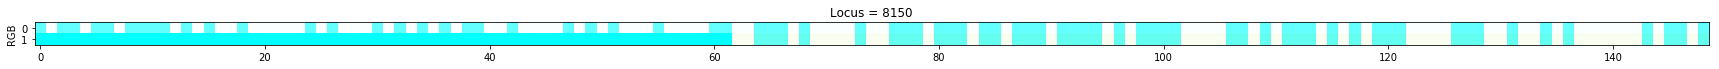

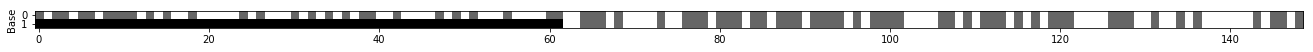

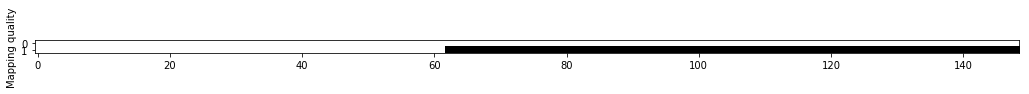

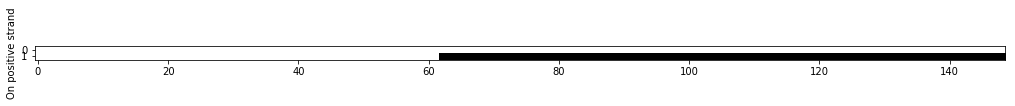

In [50]:
x = unserialized_data['scaffold161|size1025551|543642 to 552805']
visualization_locus(8150, x)

95


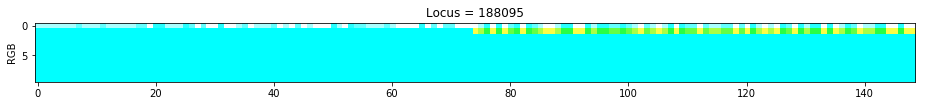

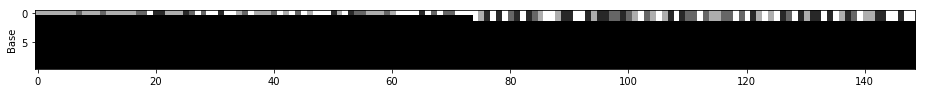

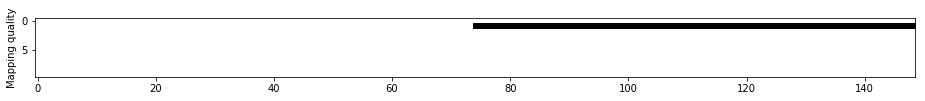

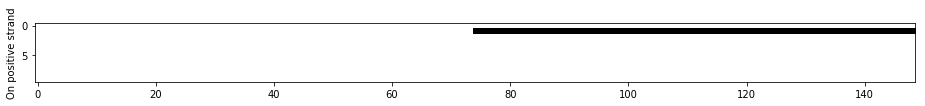

In [51]:
locus = 188095
visualization_locus(locus, FINAL_RGB)

In [55]:
FINAL_RGB[1,:,:,0]

array([[  0,   0,   0, ..., 100, 250, 170],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

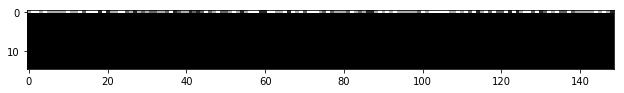

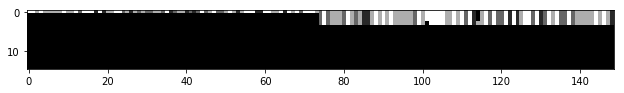

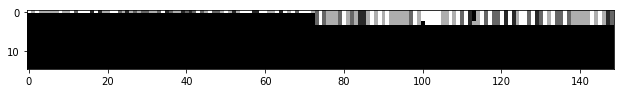

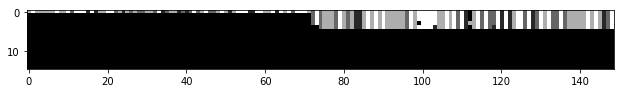

In [371]:
plt.figure(figsize=(50,5))
plt.subplot(4,1,1)
plt.imshow(pre_image_base_color[0,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,2,2)
plt.imshow(pre_image_base_color[1,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,3,3)
plt.imshow(pre_image_base_color[2,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,4,4)
plt.imshow(pre_image_base_color[3,:,:],cmap='gray')
plt.show()

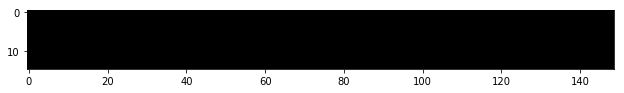

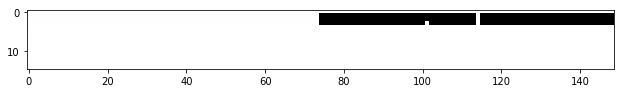

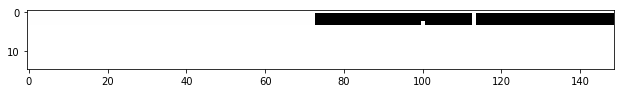

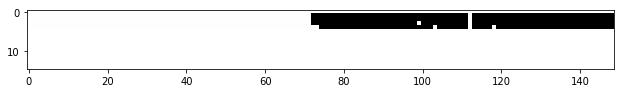

In [388]:
plt.figure(figsize=(50,5))
plt.subplot(4,1,1)
plt.imshow(pre_image_match_ref[0,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,2,2)
plt.imshow(pre_image_match_ref[1,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,3,3)
plt.imshow(pre_image_match_ref[2,:,:],cmap='gray')
plt.show()
plt.figure(figsize=(50,5))
plt.subplot(4,4,4)
plt.imshow(pre_image_match_ref[3,:,:],cmap='gray')
plt.show()

30